# Classification: Predicting Diabetes Based on Modifiable Factors

(max 2000 written words, not including citations)

# Introduction

- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

**Research question:**
Can the 5 following modifiable/reversible factors predict the onset of diabetes within 5 years with a high degree of accuracy (>75%)?
1. Plasma glucose concentration level at 2 hours in an oral glucose tolerance test (ie. glucose test, mg/dl)
2. Diastolic blood pressure (mmHg)
3. Triceps skin fold thickness - a measure of body fat (mm)
4. 2-Hour serum insulin (µU/mL)
5. Body mass index (kg/m^2)



# Methods

- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.

# Analysis

- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs the data analysis

## Diabetes Dataset

Our dataset was obtained from Kaggle at the following URL: 

https://www.kaggle.com/datasets/mathchi/diabetes-data-set?fbclid=IwAR1DMzdJFDxoEqLDIZNTi3j7YJXTx_7BJwCl7sbn8syQKbQCnHfMtlsKH1E

This dataset was uploaded by user Mehmet Akturk and was sourced from the National Institute of Diabetes and Digestive and Kidney Diseases (donated by RMI Group Leader Vincent Sigillito).

The study population consisted of 768 female patients of at least 21 years of age and Pima Indian heritage, living near Phoenix, Arizona, USA. Researchers collected the following data:
 1. Number of times pregnant
 2. Plasma glucose concentration level at 2 hours in an oral glucose tolerance test (ie. glucose test, mg/dl)
 3. Diastolic blood pressure (mmHg)
 4. Triceps skin fold thickness - a measure of body fat (mm)
 5. 2-Hour serum insulin (µU/mL)
 6. Body mass index (kg/m^2)
 7. Diabetes pedigree function (probability of diabetes based on family history) 
 8. Age
 9. Outcome (0 = glucose test negative for diabetes 5+ years after data collection, 1 = glucose test positive for diabetes within 5 years of data collection)

Diabetes was diagnosed by a plasma glucose concentration level greater than 200 mg/dl at 2 hours in an oral glucose tolerance test. All patients had a negative glucose test for diabetes at initial data collection. 

## Importing and Tidying Data

Ensure that the following packages are installed before proceeding:

In [1]:
# installation packages commented out for convenience.
#install.packages("tidyverse")
#install.packages("tidymodels")
#install.packages("gridExtra")
#install.packages("repr")
#install.packages("kknn")

Set seed and load necessary packages.

In [2]:
# set seed and load necessary packages

set.seed(1000)

library("rlang")
library("tidyverse")
library("gridExtra")
library("repr")
library("kknn")
library("tidymodels")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%@%()         masks rlang::%@%()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks rlang::flatten()
✖ purrr::flatten_chr() masks rlang::flatten_chr()
✖ purrr::flatten_dbl() masks rlang::flatten_dbl()
✖ purrr::flatten_int() masks rlang::flatten_int()
✖ purrr::flatten_lgl() masks rlang::flatten_lgl()
✖ purrr::flatten_raw() masks rlang::flatten_raw()
✖ purrr::invoke()      masks rlang::invoke()
✖ dplyr::lag()         masks stats::lag()
✖ purrr::splice()      masks rlang::splice()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The 

Read in "diabetes.csv" from the DSCI_100_Diabetes_Prediction repository on GitHub.

In [3]:
# read in data

diabetes_dataset <- read_csv("https://raw.githubusercontent.com/hesoru/DSCI_100_Diabetes_Prediction/main/Dataset/diabetes.csv")

head(diabetes_dataset)
dim(diabetes_dataset)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


[1] 768   9

We will remove irreversible or non-modifiable variables from our classifier: pregnancies (not a reversible variable), diabetes pedigree function (probability of diabetes based on family history, not modifiable), and age.

The dataset has no N/A values, however some cells have a value equal to 0. Glucose, blood pressure, skin thickness, insulin, and BMI cannot have a reading of 0 in practice. Cells with value of 0 in these columns will be treated as N/A and filtered out.

In [4]:
diabetes_dataset_filtered <- diabetes_dataset |>
    select(-Pregnancies, -DiabetesPedigreeFunction, -Age) |>
    filter(Glucose != 0, BloodPressure != 0, SkinThickness != 0, Insulin != 0, BMI != 0)

head(diabetes_dataset_filtered)
dim(diabetes_dataset_filtered)

Glucose,BloodPressure,SkinThickness,Insulin,BMI,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89,66,23,94,28.1,0
137,40,35,168,43.1,1
78,50,32,88,31.0,1
197,70,45,543,30.5,1
189,60,23,846,30.1,1
166,72,19,175,25.8,1


[1] 392   6

Note that we have filtered out approximately half of the patients in our dataset, with a final sample size of n = 392.

## Splitting Data into Training and Testing Sets

Now that our data is tidy, we will split our data into training (75% of the data) and testing (25% of the data) sets, and convert the categorical variable Outcome into the factor data type.

In [5]:
diabetes_dataset_filtered_split <- initial_split(data = diabetes_dataset_filtered,
                                                 prop = 0.75,
                                                 strata = Outcome)
training_filtered <- training(diabetes_dataset_filtered_split) |>
    mutate(Outcome = as_factor(Outcome))
testing_filtered <- testing(diabetes_dataset_filtered_split) |>
    mutate(Outcome = as_factor(Outcome))

head(training_filtered)
dim(training_filtered)

head(testing_filtered)
dim(testing_filtered)

Glucose,BloodPressure,SkinThickness,Insulin,BMI,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
89,66,23,94,28.1,0
103,30,38,83,43.3,0
126,88,41,235,39.3,0
97,66,15,140,23.2,0
145,82,19,110,22.2,0
88,58,11,54,24.8,0


[1] 293   6

Glucose,BloodPressure,SkinThickness,Insulin,BMI,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
143,94,33,146,36.6,1
158,76,36,245,31.6,1
111,72,47,207,37.1,1
88,66,21,23,24.4,0
150,66,42,342,34.7,0
100,88,60,110,46.8,0


[1] 99  6

## Exploration of Training Data

In [6]:
patient_means_by_outcome <- training_filtered |>
    group_by(Outcome) |>
    summarise(Patients = n(),
              Mean_Glucose = mean(Glucose),
              Mean_BP = mean(BloodPressure),
              Mean_SkinThickness = mean(SkinThickness),
              Mean_Insulin = mean(Insulin),
              Mean_BMI = mean(BMI))
patient_means_by_outcome

Outcome,Patients,Mean_Glucose,Mean_BP,Mean_SkinThickness,Mean_Insulin,Mean_BMI
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,196,111.7806,69.04592,27.00510,132.1735,31.98520
1,97,147.1856,74.73196,33.06186,207.3196,35.72062


- 0 = negative glucose test for diabetes 5 years after data collection
- 1 = positive glucose test for diabetes within 5 years of data collection

**Interpretation:**
- 97/293 patients received a positive glucose test for diabetes (1) within 5 years of data collection. This implies a startling rate of diabetes development, however it is possible that some patients were already diabetic at data collection (false negatives).
- There is a large relative difference (at least 25%) in Mean_Glucose and Mean_Insulin between pre-diabetics and non-diabetics.

In [7]:
options(repr.plot.width = 9, repr.plot.height = 6)

patient_distribution_glucose <- training_filtered |>
    ggplot(aes(x = Glucose)) +
    geom_histogram(bins = 10, binwidth = 5) +
    labs(x = "Glucose Plasma Concentration (mg/dl)",
         y = "Number of Patients") +
    theme(text = element_text(size = 10)) +
    theme(legend.position = "none")

patient_distribution_BP <- training_filtered |>
    ggplot(aes(x = BloodPressure)) +
    geom_histogram(bins = 10, binwidth = 4) +
    labs(x = "Diastolic Blood Pressure (mmHg)",
         y = "Number of Patients") +
    theme(text = element_text(size = 10)) +
    theme(legend.position = "none")

patient_distribution_SkinThickness <- training_filtered |>
    ggplot(aes(x = SkinThickness)) +
    geom_histogram(bins = 10, binwidth = 2) +
    labs(x = "Tricep Skin Thickness (mm)",
         y = "Number of Patients") +
    theme(text = element_text(size = 10)) +
    theme(legend.position = "none")

patient_distribution_Insulin <- training_filtered |>
    ggplot(aes(x = Insulin)) +
    geom_histogram(bins = 10, binwidth = 25) +
    labs(x = "2-Hour Serum Insulin (µU/mL)",
         y = "Number of Patients") +
    theme(text = element_text(size = 10)) +
    theme(legend.position = "none")

patient_distribution_BMI <- training_filtered |>
    ggplot(aes(x = BMI)) +
    geom_histogram(bins = 10, binwidth = 2) +
    labs(x = "Body Mass Index (kg/m^2)",
         y = "Number of Patients") +
    theme(text = element_text(size = 10)) +
    theme(legend.position = "none")

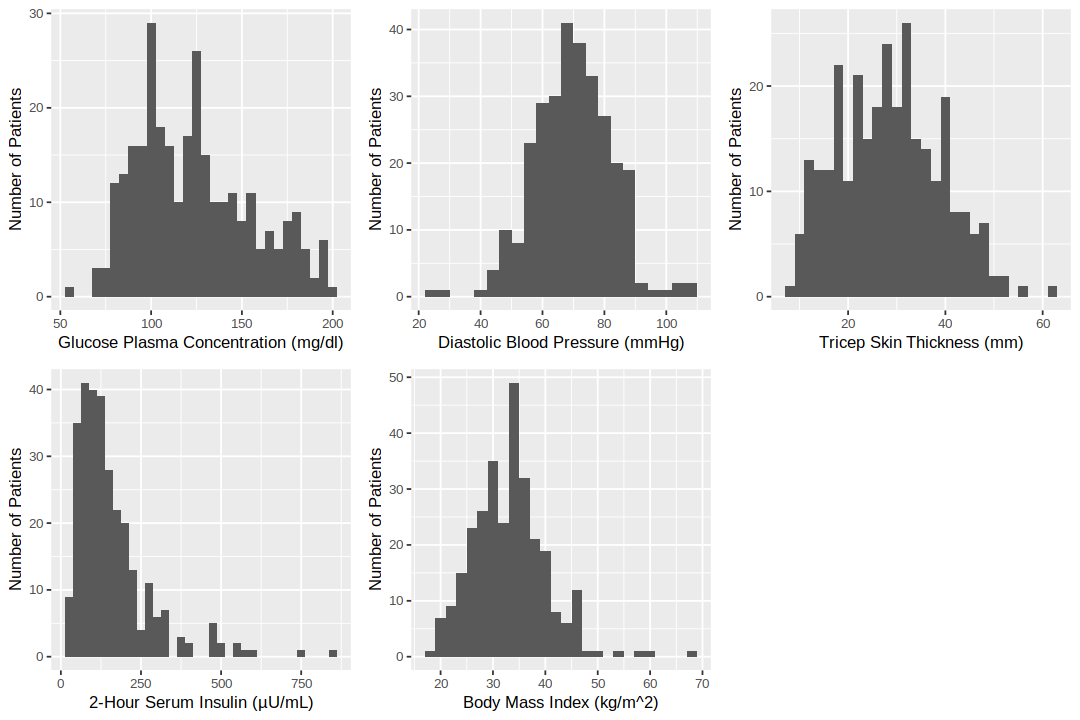

In [8]:
grid.arrange(patient_distribution_glucose,
             patient_distribution_BP,
             patient_distribution_SkinThickness,
             patient_distribution_Insulin,
             patient_distribution_BMI,
             ncol=3)

**Normal ranges (cite source)**
- Glucose plasma concentration: < 140 mg/dl
- Diastolic BP: < 80 mmHg
- Tricep skin thickness: 23.6 ± 7.5 mm
- 2-hour Serum Insulin: 16-166 uU/mL
- BMI: 18.5 to 24.9

**Interpretation:**
- Glucose plasma concentration is a normal distribution skewed to the left: the long tail to the right implies diabetics with abnormal blood glucose
- Diastolic BP is a normal distribution centered around 70 mmHg, with a small subset to the right with diastolic hypertension 
- ...
- BMI is a normal distribution centered around 35 kg/m^2, which falls into the obese range


## Selecting K for the Classifier

First we will set up the model recipe, specifications, split the training data into 10 subsets for cross-validation, and set the k values to test.

In [23]:
set.seed(1000)

knn_recipe <- recipe(Outcome ~ ., data = training_filtered) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

vfold <- vfold_cv(training_filtered, v = 10, strata = Outcome)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

In [26]:
knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = vfold, grid = k_vals) |>
  collect_metrics() 
                 
accuracies <- knn_results |>
    filter(.metric =="accuracy")
accuracies 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6968227,10,0.03208752,Preprocessor1_Model01
6,accuracy,binary,0.7647783,10,0.02642897,Preprocessor1_Model02
11,accuracy,binary,0.7318062,10,0.03131951,Preprocessor1_Model03
16,accuracy,binary,0.7556158,10,0.02942854,Preprocessor1_Model04
21,accuracy,binary,0.7760920,10,0.02603362,Preprocessor1_Model05
26,accuracy,binary,0.7727586,10,0.02684275,Preprocessor1_Model06
31,accuracy,binary,0.7515681,10,0.02271218,Preprocessor1_Model07
36,accuracy,binary,0.7419294,10,0.02630906,Preprocessor1_Model08
41,accuracy,binary,0.7414532,10,0.02581852,Preprocessor1_Model09


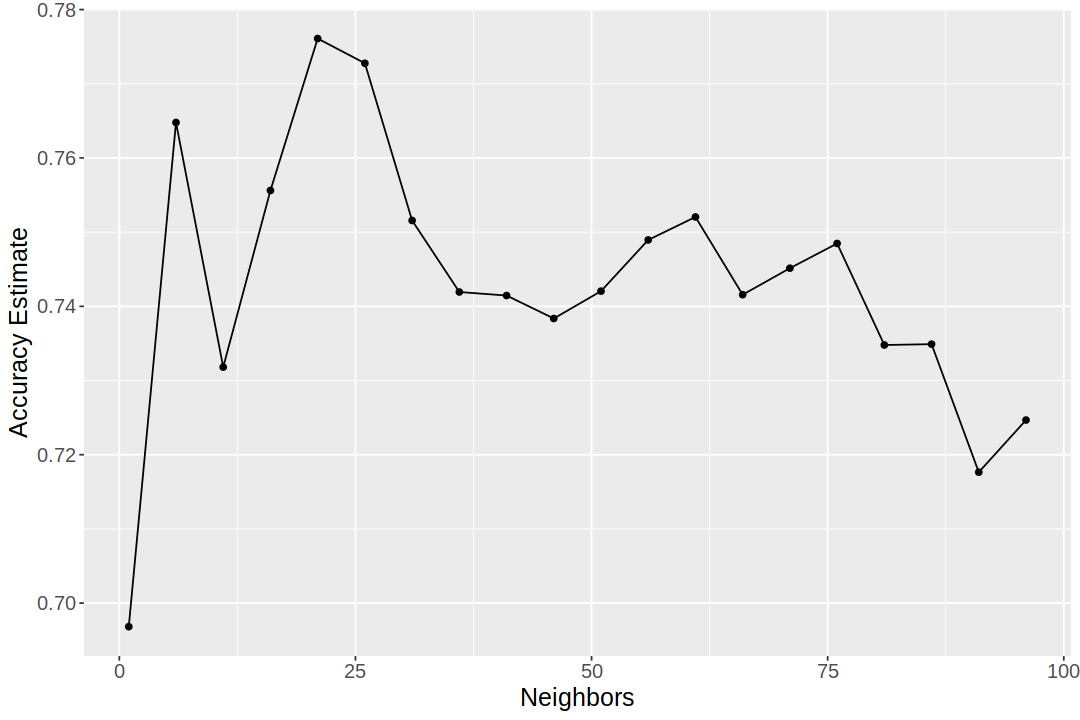

In [27]:
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 15))

cross_val_plot

Setting the number of neighbors to K = 21 provides the highest accuracy, thus we will move forward using this K-value for the classification.

## Training the Classifier

Now we will combine our recipe, KNN specification (with a new K), and training data to train our model.

In [34]:
set.seed(1000)

# our knn_recipe was defined previously when tuning the classifier

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |> 
    set_engine("kknn") |>
    set_mode("classification")

mnist_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(mnist_spec) |>
    fit(data = training_filtered)

## Evaluating the Classifier's Performance

We will build a confusion matrix based off our classifier's labelling.

In [36]:
set.seed(1000)

mnist_predictions <- predict(mnist_fit, testing_filtered) |>
    bind_cols(testing_filtered)

mnist_metrics <- mnist_predictions |>
    metrics(truth = Outcome, estimate = .pred_class) |>
    filter(.metric == "accuracy")

mnist_conf_mat <- mnist_predictions |>
    conf_mat(truth = Outcome, estimate = .pred_class)

mnist_conf_mat

          Truth
Prediction  0  1
         0 61 19
         1  5 14

## $ \textrm{accuracy} = \frac{\textrm{number of correct predictions}}{\textrm{total number of predictions}} = \frac{\textrm{61 + 14}}{\textrm{61 + 19 + 5 + 14}} = 0.7576 $

## $ \textrm{precision} = \frac{\textrm{number of correct positive predictions}}{\textrm{total number of positive predictions}} = \frac{\textrm{14}}{\textrm{14 + 5}} = 0.7368 $

## $ \textrm{recall} = \frac{\textrm{number of correct positive predictions}}{\textrm{total number of positive test set predictions}} = \frac{\textrm{14}}{\textrm{14 + 19}} = 0.4242 $

Our primary objective is to identify pre-diabetic patients among the Pima Indian population, with the goal of initiating lifestyle modifications to hopefully prevent the onset of diabetes.

The accuracy of our classifier is quite high, identifying whether or not patients are pre-diabetic 75.76% of the time. However, our classifier is less reliable with correctly identifying pre-diabetics, identifying just 42.42% of pre-diabetic patients. Though the recall of this classifier needs to be improved, it is still an improvement on the current medical system, which does not tend to identify *any* pre-diabetic patients.

There are minimal consequences to the classifier labeling a false-negative result (19.19%), as pre-diabetic patients that are missed do not yet require treatment. There are also minimal consequences to the classifier labeling a false-positive result (5.051%), as any patient would benefit from the lifestyle modifications that prevent the onset of diabetes.

# Results

- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- creates a visualization of the analysis 
- note: all tables and figure should have a figure/table number and a legend

# Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

# References

(APA style)

- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.